# Description

This notebook performs EDA on the crypto prices and returns.

# Imports

In [1]:
# %load_ext autoreload
# %autoreload 2
# %matplotlib inline

In [2]:
# TODO(Grisha): move to `core/dataflow_model/notebooks` in #205.

import logging
import os

import pandas as pd
import pytz

import core.config.config_ as cconconf
import core.explore as coexplor
import core.plotting as coplotti
import helpers.datetime_ as hdateti
import helpers.dbg as hdbg
import helpers.env as henv
import helpers.printing as hprint
import helpers.s3 as hs3
import im_v2.ccxt.data.client.loader as imcdacllo

/app/core/explore.py:39: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tauton


In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-9d2331f6-9a23-498e-a22d-49e0bb15c024.json'
>>ENV<<: is_inside_container=True: code_version=None, container_version=cmamp-1.0.0, is_inside_docker=True, is_inside_ci=False, CI_defined=True, CI=''
>>ENV<<: AM_AWS_PROFILE=True AM_ECR_BASE_PATH=True AM_S3_BUCKET=True AM_TELEGRAM_TOKEN=True AWS_ACCESS_KEY_ID=False AWS_DEFAULT_REGION=False AWS_SECRET_ACCESS_KEY=False GH_ACTION_ACCESS_TOKEN=True
-----------------------------------------------------------------------------
This code is not in sync with the container:
code_version='None' != container_version='cmamp-1.0.0'
-----------------------------------------------------------------------------
You need to:
- merge origin/master into your branch with `invoke git_merge_master`
- pull the latest container with `invoke docker_pull`
# Git
    branch_name='CmTask456_Refactor_CCXT_loader_in_im_v2'
    hash='841fba91'
    # Last commits

# Config

In [4]:
def get_eda_config() -> cconconf.Config:
    """
    Get config that controls EDA parameters.
    """
    config = cconconf.Config()
    # Load parameters.
    config.add_subconfig("load")
    config["load"]["aws_profile"] = "am"
    config["load"]["data_dir"] = os.path.join(hs3.get_path(), "data")
    # Data parameters.
    config.add_subconfig("data")
    config["data"]["close_price_col_name"] = "close"
    config["data"]["frequency"] = "T"
    # TODO(Grisha): use `hdateti.get_ET_tz()` once it is fixed.
    config["data"]["timezone"] = pytz.timezone("US/Eastern")
    # Statistics parameters.
    config.add_subconfig("stats")
    config["stats"]["z_score_boundary"] = 3
    config["stats"]["z_score_window"] = "D"
    return config


config = get_eda_config()
print(config)

load:
  aws_profile: am
  data_dir: s3://alphamatic-data/data
data:
  close_price_col_name: close
  frequency: T
  timezone: US/Eastern
stats:
  z_score_boundary: 3
  z_score_window: D


# Load data

In [6]:
# TODO(Grisha): allow loading multiple assets/exchanges/currencies #219.

In [7]:
# TODO(Grisha): potentially read data from the db.
ccxt_loader = imcdacllo.CcxtLoaderFromFile(
    root_dir=config["load"]["data_dir"], aws_profile=config["load"]["aws_profile"]
)
ccxt_data = ccxt_loader.read_data(
    exchange_id="binance", currency_pair="BTC/USDT", data_type="OHLCV"
)
_LOG.info("shape=%s", ccxt_data.shape[0])
ccxt_data.head(3)

Reading CCXT data for exchange id='binance', currencies='BTC/USDT' from file='s3://alphamatic-data/data/ccxt/20210924/binance/BTC_USDT.csv.gz'...
Processing CCXT data for exchange id='binance', currencies='BTC/USDT'...
Index length increased by 4519 = 1619641 - 1615122
shape=1619641


,open,high,low,close,volume,epoch,currency_pair,exchange_id
2018-08-16 20:00:00-04:00,6316.00,6319.04,6310.32,6311.64,9.967395,1.534464e+12,BTC/USDT,binance
2018-08-16 20:01:00-04:00,6311.64,6311.77,6302.81,6302.81,16.781206,1.534464e+12,BTC/USDT,binance
2018-08-16 20:02:00-04:00,6302.81,6306.00,6292.79,6297.26,55.373226,1.534464e+12,BTC/USDT,binance


In [6]:
# Check the timezone info.
hdbg.dassert_eq(
    ccxt_data.index.tzinfo,
    config["data"]["timezone"],
)

AssertionError: 
################################################################################
* Failed assertion *
'America/New_York'
==
'US/Eastern'
################################################################################


In [7]:
# TODO(Grisha): change tz in `CcxtLoader` #217.
ccxt_data.index = ccxt_data.index.tz_convert(config["data"]["timezone"])
ccxt_data.index.tzinfo

<DstTzInfo 'US/Eastern' LMT-1 day, 19:04:00 STD>

# Select subset

In [8]:
ccxt_data_subset = ccxt_data[[config["data"]["close_price_col_name"]]]
ccxt_data_subset.head(3)

,close
timestamp,
2018-08-16 20:00:00-04:00,6311.64
2018-08-16 20:01:00-04:00,6302.81
2018-08-16 20:02:00-04:00,6297.26


# Resample index

In [9]:
# TODO(Grisha): do we want to merge it with `core.pandas_helpers.resample_index`?
# The problem with `resample_index` in `pandas_helpers` is that it does not
# generate empty rows for missing timestamps.
def resample_index(index: pd.DatetimeIndex, frequency: str) -> pd.DatetimeIndex:
    """
    Resample `DatetimeIndex`.

    :param index: `DatetimeIndex` to resample
    :param frequency: frequency from `pd.date_range()` to resample to
    :return: resampled `DatetimeIndex`
    """
    hdbg.dassert_isinstance(index, pd.DatetimeIndex)
    min_date = index.min()
    max_date = index.max()
    resampled_index = pd.date_range(
        start=min_date,
        end=max_date,
        freq=frequency,
    )
    return resampled_index


resampled_index = resample_index(
    ccxt_data_subset.index, config["data"]["frequency"]
)
ccxt_data_reindex = ccxt_data_subset.reindex(resampled_index)
_LOG.info("shape=%s", ccxt_data_reindex.shape[0])
ccxt_data_reindex.head(3)

shape=1619641


,close
2018-08-16 20:00:00-04:00,6311.64
2018-08-16 20:01:00-04:00,6302.81
2018-08-16 20:02:00-04:00,6297.26


# Filter data

In [10]:
# TODO(Grisha): add support for filtering by exchange, currency, asset class.

In [13]:
# Get the inputs.
# TODO(Grisha): pass tz to `hdateti.to_datetime` once it is fixed.
lower_bound = hdateti.to_datetime("2019-01-01")
lower_bound_ET = config["data"]["timezone"].localize(lower_bound)
upper_bound = hdateti.to_datetime("2020-01-01")
upper_bound_ET = config["data"]["timezone"].localize(upper_bound)
# Fiter data.
ccxt_data_filtered = coexplor.filter_by_time(
    df=ccxt_data_reindex,
    lower_bound=lower_bound_ET,
    upper_bound=upper_bound_ET,
    inclusive="left",
    ts_col_name=None,
    log_level=logging.INFO,
)
ccxt_data_filtered.head(3)

Filtering between 2019-01-01 00:00:00-05:00 and 2020-01-01 00:00:00-05:00 with inclusive=`left`, selected rows=525600 / 1619641 = 32.45%


,close
2019-01-01 00:00:00-05:00,3697.35
2019-01-01 00:01:00-05:00,3697.29
2019-01-01 00:02:00-05:00,3696.32


# Statistics

## Plot timeseries

<AxesSubplot:>

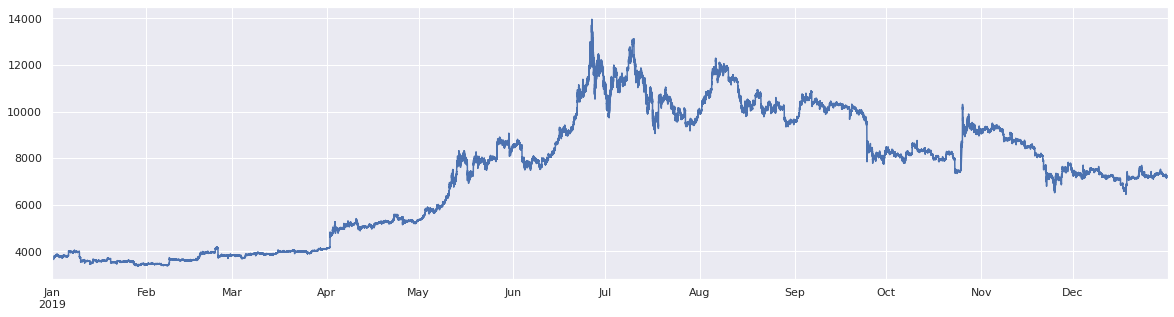

In [14]:
# TODO(Grisha): replace with a function that does the plotting.
ccxt_data_filtered[config["data"]["close_price_col_name"]].plot()

## Plot timeseries distribution

/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


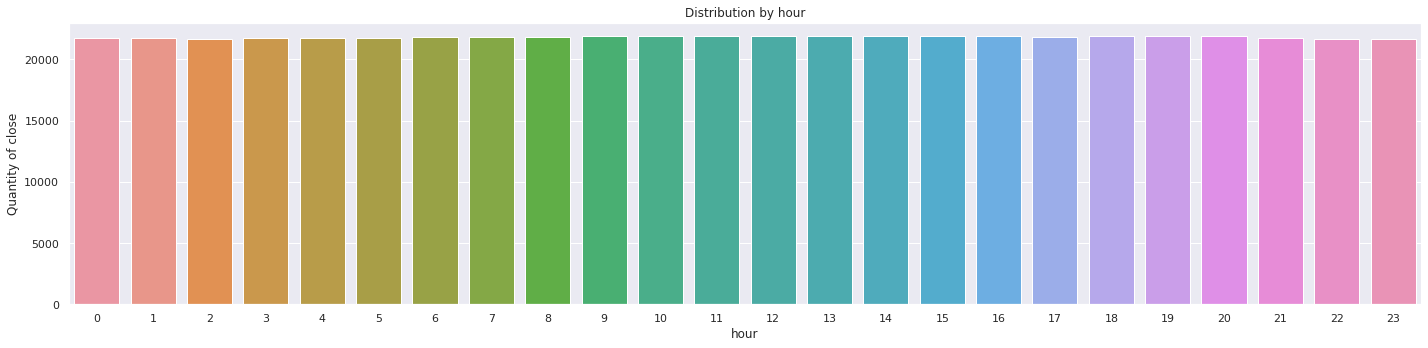

In [15]:
# TODO(Grisha): fix the function behavior in #204.
coplotti.plot_timeseries_distribution(
    ccxt_data_filtered[config["data"]["close_price_col_name"]],
    datetime_types=["hour"],
)

## NaN statistics

In [16]:
nan_stats_df = coexplor.report_zero_nan_inf_stats(ccxt_data_filtered)
nan_stats_df

index in [2019-01-01 00:00:00-05:00, 2019-12-31 23:59:00-05:00]
num_rows=525,600
data=


,close
2019-01-01 00:00:00-05:00,3697.35
2019-01-01 00:01:00-05:00,3697.29
...,...
2019-12-31 23:58:00-05:00,7216.67
2019-12-31 23:59:00-05:00,7217.27


num_days=365
num_weekdays=261


,num_rows,zeros [%],nans [%],infs [%],valid [%]
close,525600,0.0,0.34,0.0,99.66


,num_rows,zeros [%],nans [%],infs [%],valid [%]
close,525600,0.0,0.34,0.0,99.66


In [17]:
# TODO(Grisha): pretify the function: add assertions, logging.
# TODO(Grisha): add support for zeros, infinities.
# TODO(Grisha): also count NaNs by exchange, currency, asset class.
def count_nans_by_period(
    df: pd.DataFrame,
    config: cconconf.Config,
    period: str,
    top_n: int = 10,
) -> pd.DataFrame:
    """
    Count NaNs by period.

    :param df: data
    :param period: time period, e.g. "D" - to group by day
    :param top_n: display top N counts
    :return: table with NaN counts by period
    """
    # Select only NaNs.
    nan_data = df[df[config["data"]["close_price_col_name"]].isna()]
    # Group by specified period.
    nan_grouped = nan_data.groupby(pd.Grouper(freq=period))
    # Count NaNs.
    nan_grouped_counts = nan_grouped.apply(lambda x: x.isnull().sum())
    nan_grouped_counts.columns = ["nan_count"]
    nan_grouped_counts_sorted = nan_grouped_counts.sort_values(
        by=["nan_count"], ascending=False
    )
    return nan_grouped_counts_sorted.head(top_n)


nan_counts = count_nans_by_period(
    ccxt_data_filtered,
    config,
    "D",
)
nan_counts

,nan_count
2019-05-15 00:00:00-04:00,540.0
2019-08-15 00:00:00-04:00,360.0
2019-03-12 00:00:00-04:00,240.0
2019-11-12 00:00:00-05:00,140.0
2019-03-11 00:00:00-04:00,120.0
2019-08-14 00:00:00-04:00,120.0
2019-11-24 00:00:00-05:00,120.0
2019-06-07 00:00:00-04:00,61.0
2019-05-14 00:00:00-04:00,60.0
2019-11-13 00:00:00-05:00,3.0


## Detect outliers

In [18]:
# TODO(Grisha): add support for other approaches, e.g. IQR-based approach.
def detect_outliers(df: pd.DataFrame, config: cconconf.Config) -> pd.DataFrame:
    """
    Detect outliers in a rolling fashion using z-score.

    If an observation has abs(z-score) > `z_score_boundary` it is considered
    an outlier. To compute a `z-score` rolling mean and rolling std are used.

    :param df: data
    :return: outliers
    """
    df_copy = df.copy()
    roll = df_copy[config["data"]["close_price_col_name"]].rolling(
        window=config["stats"]["z_score_window"]
    )
    # Compute z-score for a rolling window.
    df_copy["z-score"] = (
        df_copy[config["data"]["close_price_col_name"]] - roll.mean()
    ) / roll.std()
    # Select outliers based on the z-score.
    df_outliers = df_copy[
        abs(df_copy["z-score"]) > config["stats"]["z_score_boundary"]
    ]
    return df_outliers


outliers = detect_outliers(ccxt_data_filtered, config)
_LOG.info("shape=%s", outliers.shape[0])
outliers.head(3)

shape=20927


,close,z-score
2019-01-01 01:06:00-05:00,3706.95,3.119872
2019-01-01 01:07:00-05:00,3710.40,4.048159
2019-01-01 01:09:00-05:00,3709.03,3.012456
